In [4]:
import pymongo
import pandas as pd
import numpy as np
from pymongo import MongoClient
from textstat.textstat import textstat
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pickle
from statsmodels.stats.weightstats import ztest


client = MongoClient()
db = client.cap_db
articles = pd.DataFrame(list(db.nyt.find()))

In [5]:
from scipy.stats import ttest_ind
import json

In [6]:
articles.head()

,_id,abstract,blog,body,byline,document_type,headline,keywords,multimedia,new_desk,print_page,pub_date,score,section_name,snippet,source,type_of_material,uri,web_url,word_count
0,5a4aca6e95d0e0246f21ed46,NaN,{},If the second inauguration of Mayor Bill de Bl...,"{'original': 'By J. DAVID GOODMAN', 'person': ...",article,"{'main': 'At de Blasio Inaugural, Speeches by ...","[{'name': 'subject', 'value': 'Elections, Comp...","[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",Metro,12,2018-01-01T23:55:15+0000,1.0,NaN,"Addresses by the comptroller, Scott M. Stringe...",The New York Times,News,nyt://article/a66d94b3-1a66-59a3-b113-4c2612cb...,https://www.nytimes.com/2018/01/01/nyregion/at...,936
1,5a4ac96d95d0e0246f21ed45,NaN,{},It took 37 minutes of sitting outside in 18-de...,{'original': 'By JEFFERY C. MAYS and J. DAVID ...,article,{'main': 'Weather and Visiting Senator Steal t...,"[{'name': 'subject', 'value': 'Inaugurations',...","[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",Metro,12,2018-01-01T23:50:57+0000,1.0,NaN,"In spite of the cold, crowds turned out to be ...",The New York Times,News,nyt://article/df85ed7d-a81d-5301-90a6-bc544a10...,https://www.nytimes.com/2018/01/01/nyregion/we...,1087
2,5a4ac57795d0e0246f21ed43,NaN,{},The families had striking similarities: They l...,{'original': 'By CHRISTINE HAUSER and ERNESTO ...,article,{'main': '2 American Families Are Mourned Afte...,"[{'name': 'subject', 'value': 'Aviation Accide...","[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",Express,7,2018-01-01T23:34:06+0000,1.0,Americas,Nine people from two families in New York and ...,The New York Times,News,nyt://article/508a6532-c60c-558b-b493-49a566fb...,https://www.nytimes.com/2018/01/01/world/ameri...,1344
3,5a4ac55195d0e0246f21ed42,NaN,{},"SAO PAULO — Nine inmates were killed, 14 were...","{'original': 'By REUTERS', 'person': [], 'orga...",article,{'main': 'Nine Dead in Latest Outbreak of Braz...,[],[],None,NaN,2018-01-01T23:33:31+0000,1.0,Americas,"Nine inmates were killed, 14 were injured, and...",Reuters,News,nyt://article/eab93d1e-6f7b-5d53-923e-6f63247d...,https://www.nytimes.com/reuters/2018/01/01/wor...,231
4,5a4ac2b595d0e0246f21ed40,NaN,{},When it comes to artificial intelligence and j...,"{'original': 'By ELISABETH A. MASON', 'person'...",article,{'main': 'A.I. and Big Data Could Power a New ...,"[{'name': 'subject', 'value': 'Artificial Inte...","[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",OpEd,15,2018-01-01T23:22:19+0000,1.0,NaN,Conventional wisdom says artificial intelligen...,The New York Times,Op-Ed,nyt://article/cdb799a7-7ce7-56fa-bf3b-7bd22181...,https://www.nytimes.com/2018/01/01/opinion/ai-...,836


In [7]:
len(articles)

31989

In [8]:
# Drop out Unnecessary columns

articles = articles[['_id','body','byline','document_type','headline','keywords','new_desk','print_page','pub_date','section_name','source','type_of_material','web_url','word_count']]


In [6]:
articles['byline'][0]

{'organization': None,
 'original': 'By J. DAVID GOODMAN',
 'person': [{'firstname': 'J.',
   'lastname': 'GOODMAN',
   'middlename': 'David',
   'organization': '',
   'qualifier': None,
   'rank': 1,
   'role': 'reported',
   'title': None}]}

In [7]:
articles['headline'][0]

{'content_kicker': None,
 'kicker': None,
 'main': 'At de Blasio Inaugural, Speeches by Two Who Might Replace Him',
 'name': None,
 'print_headline': 'Inauguration Heralds an Unofficial Start to the 2021 Mayoral Campaign',
 'seo': None,
 'sub': None}

In [11]:
articles[articles['word_count']<50].count().sum()

11509

In [9]:
def add_reading_levels(df):
    for row,body in enumerate(df['body']):
        x = df['body'][row]
        df.loc[row,'flesch_kincaid']=textstat.flesch_kincaid_grade(x)
        df.loc[row,'fk_score']=textstat.flesch_reading_ease(x)
        #df.loc[row,'smog_index']=textstat.smog_index(x)
        #df.loc[row,'gunning_fog']=textstat.gunning_fog(x)
        #df.loc[row,'difficult_words']=textstat.difficult_words(x)
        #df.loc[row,'text_standard']=textstat.text_standard(x)

add_reading_levels(articles)

In [16]:
for row,body in enumerate(articles['body']):
    x = articles['body'][row]
    articles.loc[row,'fk_score']=textstat.flesch_reading_ease(x)

In [10]:
def add_year(df):
    df['year']=df.pub_date.apply(lambda x: int(x[:4]))

add_year(articles)

In [11]:
def drop_not_digitized(df):
    for row,x in enumerate(df['fk_score']):
        if x == 47.96:
            df.drop(row,inplace=True)

drop_not_digitized(articles)

In [12]:
def del_rows():
    '''
    Get rid of rows where there was no body of text 
    '''
    delete = []
    for row,x in enumerate(articles['body']):
        if len(x)<2:
            print(row,x)
            delete.append(row)
    
    for x in delete:
        articles.drop(x,inplace=True)

    return articles.reset_index()

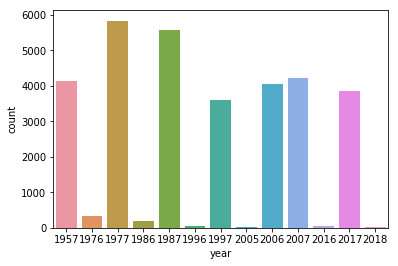

In [13]:
sns.countplot(x="year",data=articles)

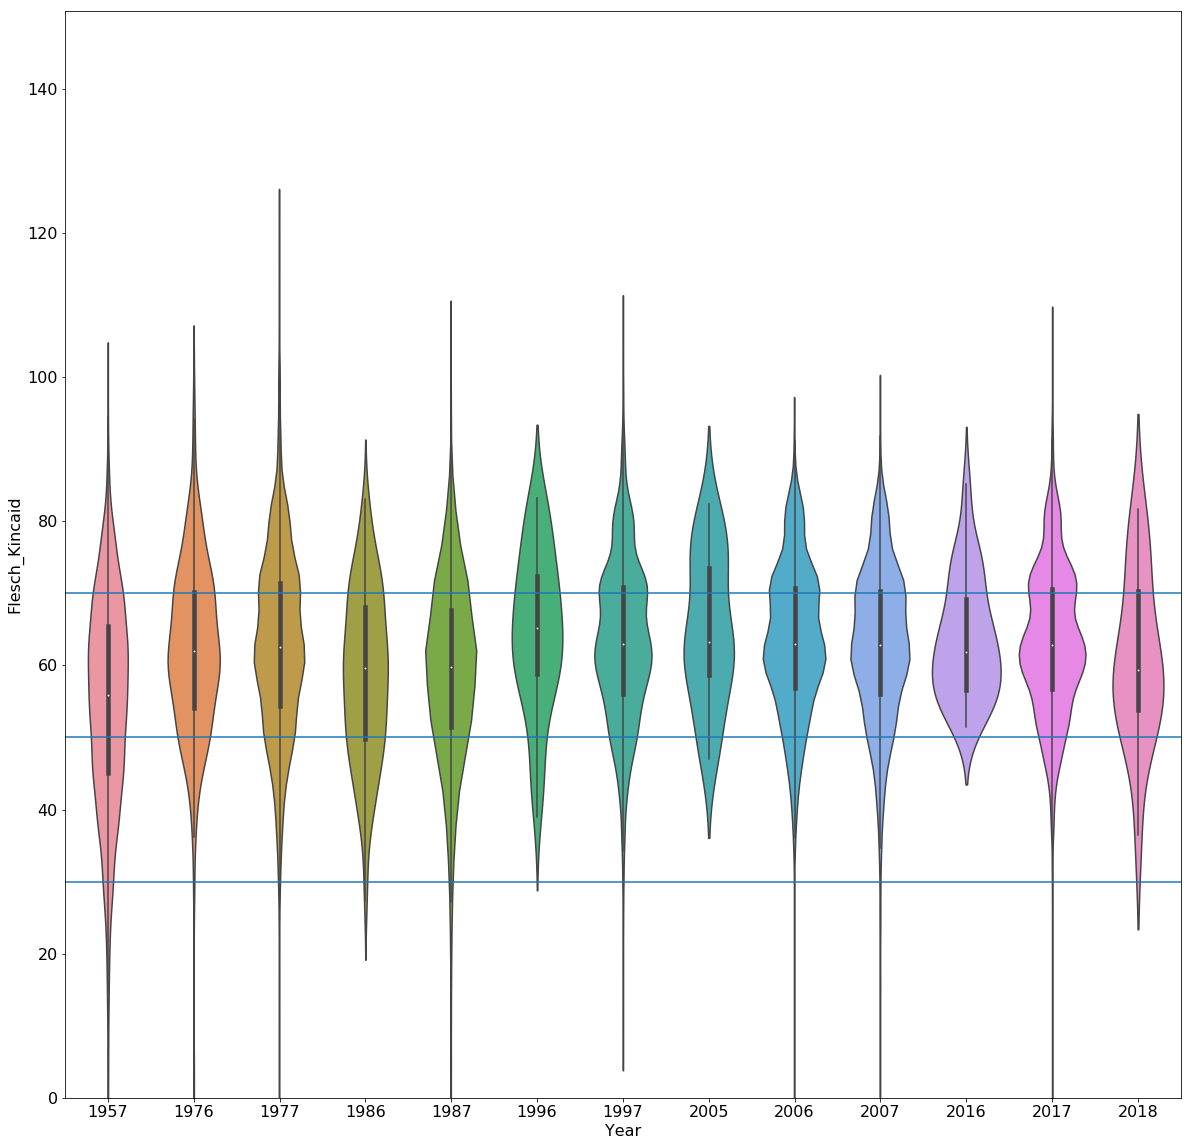

In [37]:

fig = plt.figure(figsize=(20,20))
ax = sns.violinplot(x='year',y='fk_score',data=articles)
ax.axhline(y=30)#PhD
ax.axhline(y=50)#College
ax.axhline(y=70)#8th Grade
ax.set_ylim(bottom=0)
ax.tick_params('both',labelsize=16)
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Flesch_Kincaid', fontsize=16)
plt.show()

In [45]:
'''
UTILIZING THE STATSMODELS ZTEST
'''
comb = list(itertools.combinations(articles.year.unique(),2))

_2017vs = [x for x in comb if 2017 in x]

#Need to look how to do an np.random.choice(x,size=50)

for x in _2017vs: 
    
    #y2017= np.array(articles.loc[articles['year'] == x[0], 'fk_score'].sample(len(articles['year']==2017)))#[:3500]
    y2017= np.array(articles.loc[articles['year'] == x[0], 'fk_score'])#[:3500]
    y_test = np.array(articles.loc[articles['year'] == x[1], 'fk_score'])#[:3500]
    
    if y2017.mean()>y_test.mean():
        alt = 'larger'
    else:
        alt = 'smaller'
    
    ttest, pval = ztest(y2017,y_test,alternative=alt)
    
    print('H0: {} = {}'.format(x[0],x[1]))
    print('H1: {} != {}'.format(x[0],x[1]))
    print('{} mean flesch_kincaid {:0.3f}'.format(x[0],y2017.mean()))
    print('{} mean flesch_kincaid {:0.3f}'.format(x[1],y_test.mean()))
    print("Ztest = {:0.4f} and P-value = {}".format(ttest,pval))
    print("=====================================================")

H0: 2018 = 2017
H1: 2018 != 2017
2018 mean flesch_kincaid 60.812
2017 mean flesch_kincaid 63.203
Ztest = -0.9613 and P-value = 0.16820902073385513
H0: 2017 = 2016
H1: 2017 != 2016
2017 mean flesch_kincaid 63.203
2016 mean flesch_kincaid 63.578
Ztest = -0.2426 and P-value = 0.404140300642137
H0: 2017 = 2007
H1: 2017 != 2007
2017 mean flesch_kincaid 63.203
2007 mean flesch_kincaid 62.345
Ztest = 3.3361 and P-value = 0.0004247800527939809
H0: 2017 = 2006
H1: 2017 != 2006
2017 mean flesch_kincaid 63.203
2006 mean flesch_kincaid 63.048
Ztest = 0.6186 and P-value = 0.2680885604509474
H0: 2017 = 2005
H1: 2017 != 2005
2017 mean flesch_kincaid 63.203
2005 mean flesch_kincaid 64.964
Ztest = -0.8585 and P-value = 0.1953144923554041
H0: 2017 = 1997
H1: 2017 != 1997
2017 mean flesch_kincaid 63.203
1997 mean flesch_kincaid 63.278
Ztest = -0.3003 and P-value = 0.38197491107739967
H0: 2017 = 1996
H1: 2017 != 1996
2017 mean flesch_kincaid 63.203
1996 mean flesch_kincaid 64.720
Ztest = -1.0412 and P-val

In [15]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [180]:
new_df.year.unique()
comb

[(2017, 2007),
 (2017, 1997),
 (2017, 1977),
 (2017, 1957),
 (2017, 1987),
 (2007, 1997),
 (2007, 1977),
 (2007, 1957),
 (2007, 1987),
 (1997, 1977),
 (1997, 1957),
 (1997, 1987),
 (1977, 1957),
 (1977, 1987),
 (1957, 1987)]

In [18]:
'''
UTILIZING THE SCIPY STATS TTEST_IND
'''

comb = list(itertools.combinations(new_df.year.unique(),2))
_2017vs = [x for x in comb if 2017 in x]
pval_list = []
for x in _2017vs: 
    
    #y2017= np.array(articles.loc[articles['year'] == x[0], 'fk_score'].sample(len(articles['year']==2017)))#[:3500]
    y2017= np.array(new_df.loc[articles['year'] == x[0], 'fk_score'])#[:3500]
    y_test = np.array(new_df.loc[articles['year'] == x[1], 'fk_score'])#[:3500]
    
    if y2017.mean()>y_test.mean():
        alt = 'larger'
    else:
        alt = 'smaller'
    
    ttest, pval = ttest_ind(y2017,y_test,equal_var=False)
    pval_list.append(pval)
    print('H0: {} = {}'.format(x[0],x[1]))
    print('H1: {} != {}'.format(x[0],x[1]))
    print('{} mean flesch_kincaid {:0.3f}'.format(x[0],y2017.mean()))
    print('{} mean flesch_kincaid {:0.3f}'.format(x[1],y_test.mean()))
    print("Ztest = {:0.4f} and P-value = {}".format(ttest,pval))
    print(multipletests(pval_list,.05,method='fdr_bh'))
    print("=====================================================")


H0: 2017 = 2007
H1: 2017 != 2007
2017 mean flesch_kincaid 63.203
2007 mean flesch_kincaid 62.345
Ztest = 3.3688 and P-value = 0.0007585150116059393
(array([ True], dtype=bool), array([ 0.00075852]), 0.050000000000000044, 0.05)
H0: 2017 = 1997
H1: 2017 != 1997
2017 mean flesch_kincaid 63.203
1997 mean flesch_kincaid 63.278
Ztest = -0.2993 and P-value = 0.7646980154780152
(array([ True, False], dtype=bool), array([ 0.00151703,  0.76469802]), 0.025320565519103666, 0.025)
H0: 2017 = 1977
H1: 2017 != 1977
2017 mean flesch_kincaid 63.203
1977 mean flesch_kincaid 62.612
Ztest = 2.4292 and P-value = 0.01514914806699648
(array([ True, False,  True], dtype=bool), array([ 0.00227555,  0.76469802,  0.02272372]), 0.016952427508441503, 0.016666666666666666)
H0: 2017 = 1957
H1: 2017 != 1957
2017 mean flesch_kincaid 63.203
1957 mean flesch_kincaid 54.747
Ztest = 29.8948 and P-value = 1.7836733221019708e-185
(array([ True, False,  True,  True], dtype=bool), array([  1.51703002e-003,   7.64698015e-001, 

In [19]:
print(_2017vs)

[(2017, 2007), (2017, 1997), (2017, 1977), (2017, 1957), (2017, 1987)]


In [185]:
print(multipletests(pval_list,.05,method='fdr_bh'))
print('------------------------------------------')
print(multipletests(pval_list,.05,method='fdr_by'))

(array([ True, False,  True,  True,  True], dtype=bool), array([  1.26419169e-003,   7.64698015e-001,   1.89364351e-002,
         8.91836661e-185,   1.77116447e-065]), 0.010206218313011495, 0.01)
--------------------------------------------
(array([ True, False,  True,  True,  True], dtype=bool), array([  2.88657102e-003,   1.00000000e+000,   4.32381934e-002,
         2.03636038e-184,   4.04415886e-065]), 0.010206218313011495, 0.01)


In [103]:
import statsmodels.stats.weightstats.CompareMeans.ztest_ind as ztest_ind

ModuleNotFoundError: No module named 'statsmodels.stats.weightstats.CompareMeans'; 'statsmodels.stats.weightstats' is not a package

In [125]:
articles[articles['word_count']<100]

,_id,body,byline,document_type,headline,keywords,new_desk,print_page,pub_date,section_name,source,type_of_material,web_url,word_count,flesch_kincaid,fk_score,gunning_fog,year
70,5a4824d795d0e0246f21eafa,“Still the world’s most dangerous man.”\nDAVID...,"{'original': None, 'person': None, 'organizati...",article,{'main': 'Quotation of the Day: U.S. Pounds Al...,[],Summary,3,2017-12-30T23:43:51+0000,NaN,The New York Times,Quote,https://www.nytimes.com/2017/12/30/todayspaper...,31,5.2,72.02,18.023226,2017
99,5a47c61a95d0e0246f21ea84,VARIETY PUZZLE — Mel Taub returns with a fun P...,"{'original': 'By DEB AMLEN', 'person': [{'firs...",article,"{'main': 'Puns and Anagrams', 'kicker': 'Wordp...","[{'name': 'subject', 'value': 'Crossword Puzzl...",Games,NaN,2017-12-30T17:00:01+0000,NaN,The New York Times,News,https://www.nytimes.com/2017/12/30/crosswords/...,58,5.4,82.14,14.696552,2017
109,5a45855c95d0e0246f21e784,"It was hard to keep up with all the news, wasn...","{'original': 'By PATRICK CHAPPATTE', 'person':...",article,"{'main': 'What We Learned This Year', 'kicker'...","[{'name': 'subject', 'value': 'Sexual Harassme...",OpEd,NaN,2017-12-28T23:59:13+0000,NaN,The New York Times,Op-Ed,https://www.nytimes.com/2017/12/28/opinion/201...,12,2.1,101.60,10.133333,2017
150,5a440db195d0e0246f21e4d2,"On this week’s podcast, Greta Gerwig reads Jul...","{'original': 'By THE NEW YORK TIMES', 'person'...",article,{'main': 'Modern Love Podcast: Greta Gerwig Re...,"[{'name': 'subject', 'value': 'Podcasts', 'ran...",Styles,NaN,2017-12-27T21:16:26+0000,NaN,The New York Times,News,https://www.nytimes.com/2017/12/27/style/moder...,89,5.5,81.83,17.358202,2017
181,5a43b06e95d0e0246f21e42f,"In 2017, we captured unexpected combinations i...","{'original': None, 'person': None, 'organizati...",article,{'main': 'The Best Uses of Color in T This Yea...,"[{'name': 'subject', 'value': 'Color', 'rank':...",TStyle,NaN,2017-12-27T14:38:24+0000,NaN,The New York Times,News,https://www.nytimes.com/2017/12/27/t-magazine/...,53,12.4,53.04,23.920755,2017
215,5a42b89d95d0e0246f21e2f6,"Jake Silverstein, editor in chief: “Amanda Dem...","{'original': 'By THE NEW YORK TIMES MAGAZINE',...",article,"{'main': 'Behind the Cover: 12.24.17', 'kicker...","[{'name': 'creative_works', 'value': 'Get Out ...",Magazine,NaN,2017-12-26T21:01:08+0000,NaN,The New York Times,News,https://www.nytimes.com/2017/12/26/magazine/be...,69,11.1,56.59,21.634783,2017
225,5a42a59a95d0e0246f21e2d7,To the Editor:\n“What’s Stalling Electric Cars...,"{'original': None, 'person': None, 'organizati...",article,{'main': 'Barriers to the Electric Car Future'...,"[{'name': 'subject', 'value': 'Electric and Hy...",Letters,18,2017-12-26T19:40:01+0000,NaN,The New York Times,Letter,https://www.nytimes.com/2017/12/26/opinion/ele...,84,8.6,52.36,20.009524,2017
289,5a41adc495d0e0246f21e1aa,“It’s like a balloon. We squeeze them in this ...,"{'original': None, 'person': None, 'organizati...",article,{'main': 'Quotation of the Day: Long Fight Aga...,[],Summary,3,2017-12-26T02:02:35+0000,NaN,The New York Times,Quote,https://www.nytimes.com/2017/12/25/todayspaper...,41,6.3,74.49,17.236098,2017
304,5a4166fe95d0e0246f21e17c,Ping pong diplomacy or paddle ball?,"{'original': 'By HENG', 'person': [{'firstname...",article,"{'main': 'Heng on Trump and Xi Jinping', 'kick...","[{'name': 'subject', 'value': 'United States P...",OpEd,NaN,2017-12-25T21:00:32+0000,NaN,The New York Times,Op-Ed,https://www.nytimes.com/2017/12/25/opinion/hen...,6,4.5,73.85,17.733333,2017
354,5a40566b95d0e0246f21e0aa,OPINION\nDavid Leonhardt’s column last Monday...,"{'original': None, 'person': None, 'organizati...",article,"{'main': 'Corrections: December 25, 2017', 'ki...",[],Corrections,2,2017-12-25T01:37:40+0000,NaN,The New York Times,Correction,https://www.nytimes.com/2017/12/24/pageoneplus...,88,7.1,61.53,20.010909,2017


In [47]:
test = np.random.choice(3500,size=30)
test

array([2005, 1399, 3079, 2300, 2034, 3128, 3064, 1708, 2219, 1721, 1340,
       1783,  759,  464, 3449,  760, 3473, 2055, 3278,  251, 2593, 2372,
       3161,  149, 3347, 1950, 1873, 1953, 2998,  556])

In [64]:
t2 = np.array(articles)
x = t2[t2.loc[test]]
newT=pd.DataFrame(x)
newT.columns = ['_id','body','byline','document_type','headline','keywords','new_desk','print_page','pub_date',\
                'section_name','source','type_of_material','web_url','word_count',\
               'flesch_kincaid','gunning-fog','fk_score','year']
newT['year'].unique()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [72]:
np.array(articles.loc[articles['year']==1987,'fk_score'].sample(5))

array([ 60.65,  49.45,  63.9 ,  51.28,  51.07])

In [ ]:
#Look at total syllables 

In [83]:
from pandas.io.json import json_normalize
test = json_normalize(articles['byline'])

In [127]:
len(articles['byline'])

31987

In [24]:
'''
Adding columns for authors
'''
for row, x in enumerate(articles['byline']):
    author = articles['byline'][row]['original'][3:]
    articles.loc[row,'author']=author

TypeError: 'NoneType' object is not subscriptable

In [135]:
type(articles['byline'][0]['original'][3:])

str

In [131]:
for row, x in enumerate(articles['byline']):
    a = articles['byline'][row]['original'][3:]
    print(a)
    if row == 10:
        break

J. DAVID GOODMAN
JEFFERY C. MAYS and J. DAVID GOODMAN
CHRISTINE HAUSER and ERNESTO LONDOÑO
REUTERS
ELISABETH A. MASON
DAVID M. HALBFINGER
GREG WEINER
THE ASSOCIATED PRESS
MITCH SMITH
ADAM LIPTAK
LYDIA HOFFMAN


In [137]:
len(articles['author'].unique())


45

In [25]:
articles.head()

,_id,body,byline,document_type,headline,keywords,new_desk,print_page,pub_date,section_name,source,type_of_material,web_url,word_count,flesch_kincaid,fk_score,year,author
0,5a4aca6e95d0e0246f21ed46,If the second inauguration of Mayor Bill de Bl...,"{'original': 'By J. DAVID GOODMAN', 'person': ...",article,"{'main': 'At de Blasio Inaugural, Speeches by ...","[{'name': 'subject', 'value': 'Elections, Comp...",Metro,12,2018-01-01T23:55:15+0000,NaN,The New York Times,News,https://www.nytimes.com/2018/01/01/nyregion/at...,936,7.7,70.84,2018,J. DAVID GOODMAN
1,5a4ac96d95d0e0246f21ed45,It took 37 minutes of sitting outside in 18-de...,{'original': 'By JEFFERY C. MAYS and J. DAVID ...,article,{'main': 'Weather and Visiting Senator Steal t...,"[{'name': 'subject', 'value': 'Inaugurations',...",Metro,12,2018-01-01T23:50:57+0000,NaN,The New York Times,News,https://www.nytimes.com/2018/01/01/nyregion/we...,1087,5.6,81.73,2018,JEFFERY C. MAYS and J. DAVID GOODMAN
2,5a4ac57795d0e0246f21ed43,The families had striking similarities: They l...,{'original': 'By CHRISTINE HAUSER and ERNESTO ...,article,{'main': '2 American Families Are Mourned Afte...,"[{'name': 'subject', 'value': 'Aviation Accide...",Express,7,2018-01-01T23:34:06+0000,Americas,The New York Times,News,https://www.nytimes.com/2018/01/01/world/ameri...,1344,9.1,61.77,2018,CHRISTINE HAUSER and ERNESTO LONDOÑO
3,5a4ac55195d0e0246f21ed42,"SAO PAULO — Nine inmates were killed, 14 were...","{'original': 'By REUTERS', 'person': [], 'orga...",article,{'main': 'Nine Dead in Latest Outbreak of Braz...,[],None,NaN,2018-01-01T23:33:31+0000,Americas,Reuters,News,https://www.nytimes.com/reuters/2018/01/01/wor...,231,12.1,53.85,2018,REUTERS
4,5a4ac2b595d0e0246f21ed40,When it comes to artificial intelligence and j...,"{'original': 'By ELISABETH A. MASON', 'person'...",article,{'main': 'A.I. and Big Data Could Power a New ...,"[{'name': 'subject', 'value': 'Artificial Inte...",OpEd,15,2018-01-01T23:22:19+0000,NaN,The New York Times,Op-Ed,https://www.nytimes.com/2018/01/01/opinion/ai-...,836,10.9,51.78,2018,ELISABETH A. MASON


In [16]:
value_list=[2017,2007,1997,1987,1977,1957]
new_df = articles[articles.year.isin(value_list)]
new_df.year.unique()

array([2017, 2007, 1997, 1977, 1957, 1987])

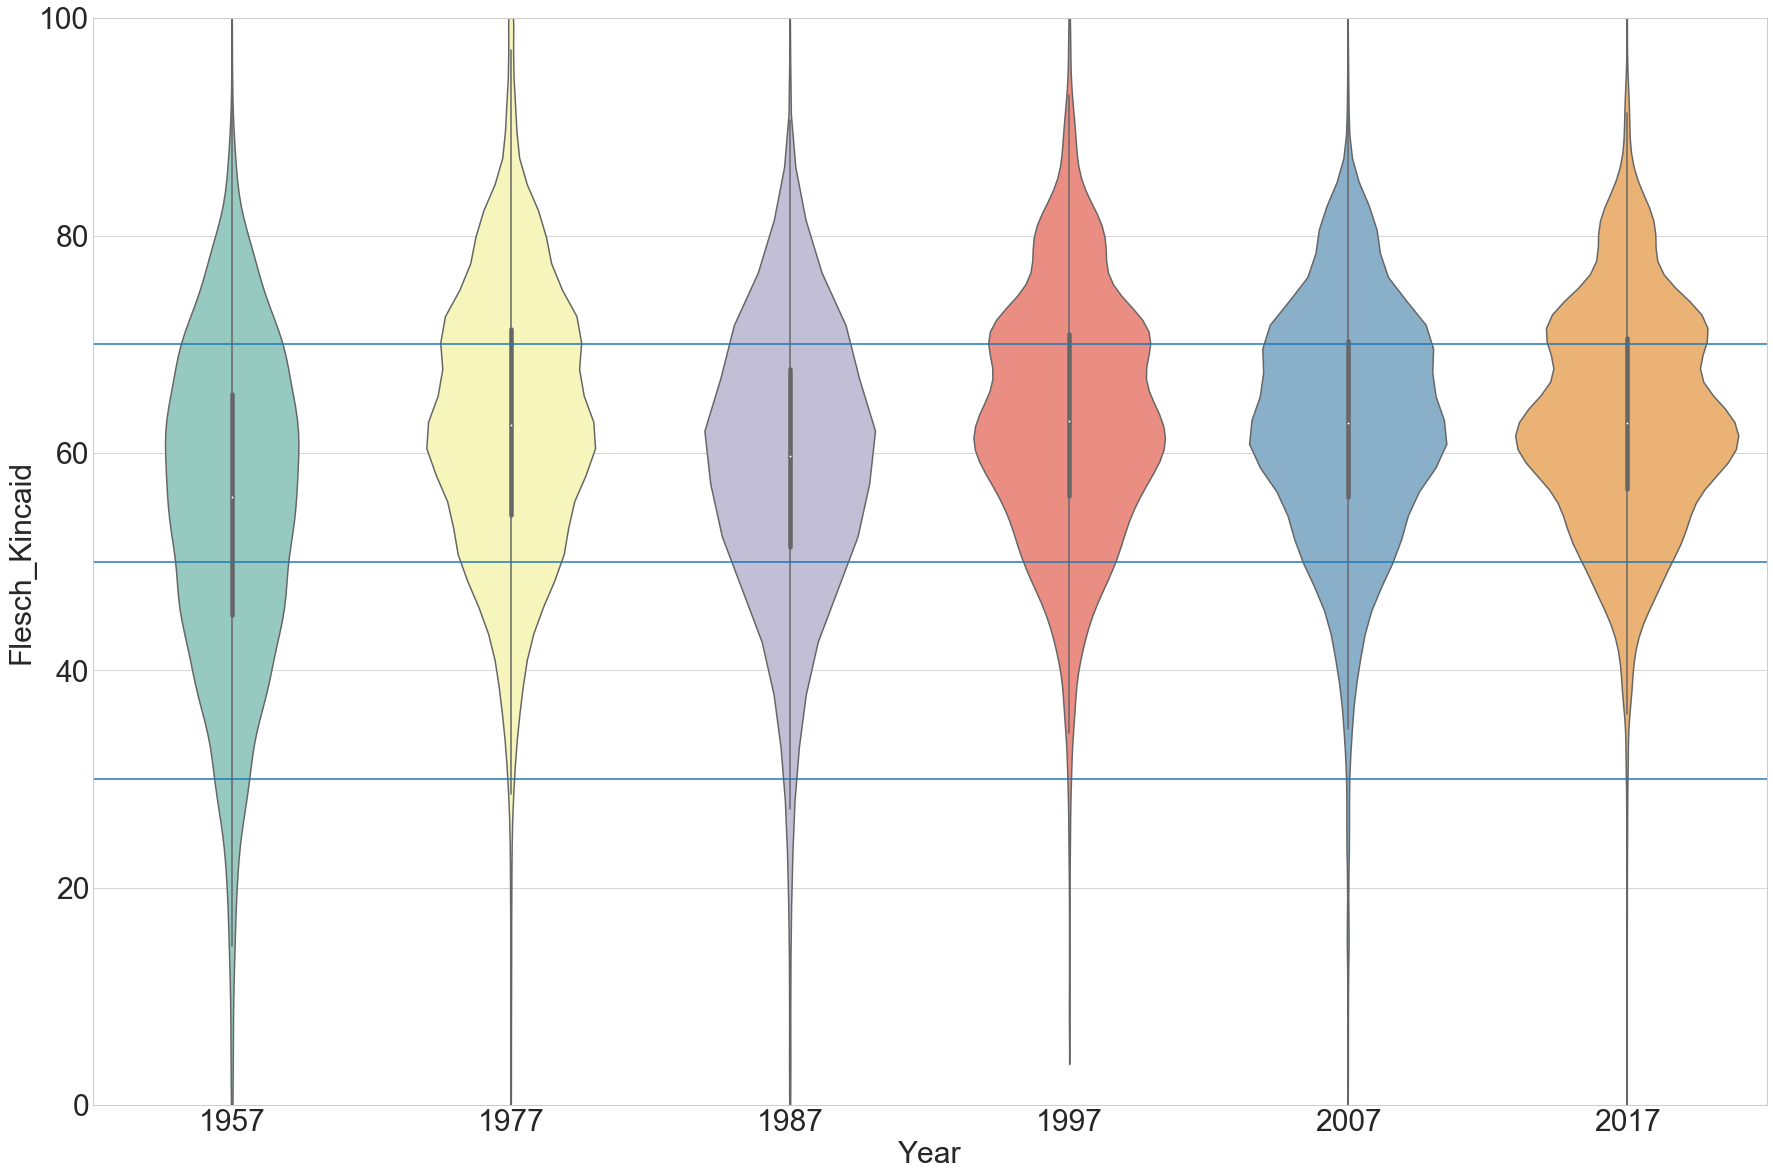

In [187]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(30,20))
ax = sns.violinplot(x='year',y='fk_score',data=new_df,palette='Set3')
ax.axhline(y=30)#PhD
ax.axhline(y=50)#College
ax.axhline(y=70)#8th Grade
ax.set_ylim(bottom=0,top=100)
ax.tick_params('both',labelsize=30)
ax.set_xlabel('Year',fontsize=30)
ax.set_ylabel('Flesch_Kincaid', fontsize=30)
ax.scatter(2017, 63.203, marker='o', color='white', s=30, zorder=3)
#sns.set_style('whitegrid')
#plt.plot(2017,63.2)
plt.savefig('fk_violin.png')

In [163]:
len(new_df)

27266

In [164]:
len(articles)

31987

In [165]:
new_df.describe()

,word_count,flesch_kincaid,fk_score,gunning_fog,year
count,27266.000000,27266.000000,27266.000000,27266.000000,27266.000000
mean,615.390890,9.149556,60.691217,18.980323,1988.971320
std,557.648997,2.976579,13.977032,3.449883,18.892441
min,0.000000,-3.500000,-364.140000,2.400000,1957.000000
25%,203.000000,7.400000,53.100000,16.880350,1977.000000
50%,529.000000,9.000000,61.460000,18.666667,1987.000000
75%,875.000000,10.600000,69.720000,20.643336,2007.000000
max,20252.000000,83.700000,121.220000,92.390950,2017.000000


In [ ]:
new_df.info()

In [22]:
textstat.flesch_kincaid_grade('There is a cooling and there is a heating, and I mean, look: It used to not be climate change. It used to be global warming.')

3.6